In [1]:
library(glmnet)
library(Matrix)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



## Generate data at 10 time points

In [2]:
N <- 50
P <- 100
sigma <- 2.0
beta_kernel <- c(1,2,3,4,5,4,3,2,1)
X_time_corr <- 0.75
time_points <- c(1:11)

beta <- matrix(nrow = P, ncol = length(time_points))
X <- list()
y <- list()

# crucial to scale X and y, otherwise solutions are different
for (t in time_points) {
    beta[,t] <- c(rep(0, t-1), beta_kernel, rep(0, P-length(beta_kernel)-(t-1)))
    if (t==1){
        X[[t]] <- scale(matrix(rnorm(N*P,mean=0,sd=1), N, P))
    } else {
        X[[t]] <- scale(X_time_corr*X[[t-1]] + (1-X_time_corr)*matrix(rnorm(N*P,mean=0,sd=1), N, P))
    }
    y[[t]] <- scale(X[[t]] %*% beta[,t] + rnorm(N, mean=0, sd=sigma))
}

In [3]:
colfunc <- colorRampPalette(c("white", "black"))

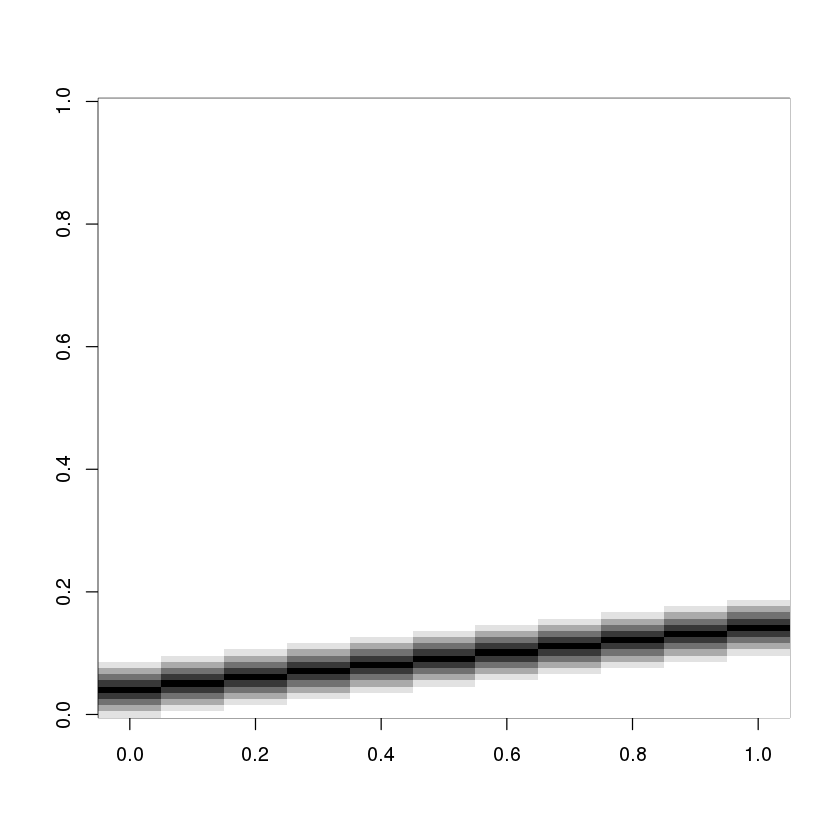

In [38]:
image(t(beta), col=colfunc(10))

## pick reasonable lambda and alpha values

In [5]:
alpha_reasonable_value <- 0.75
lambda_reasonable_value <- 0.35

## uncoupled solution

In [24]:
beta_hat <- matrix(nrow = P, ncol = length(time_points))
for (t in time_points) {
    fit <- glmnet(X[[t]], y[[t]], alpha=alpha_reasonable_value, lambda=lambda_reasonable_value,
                 intercept=FALSE, standardize=FALSE)
    beta_hat[,t] <- as.vector(fit$beta)
}

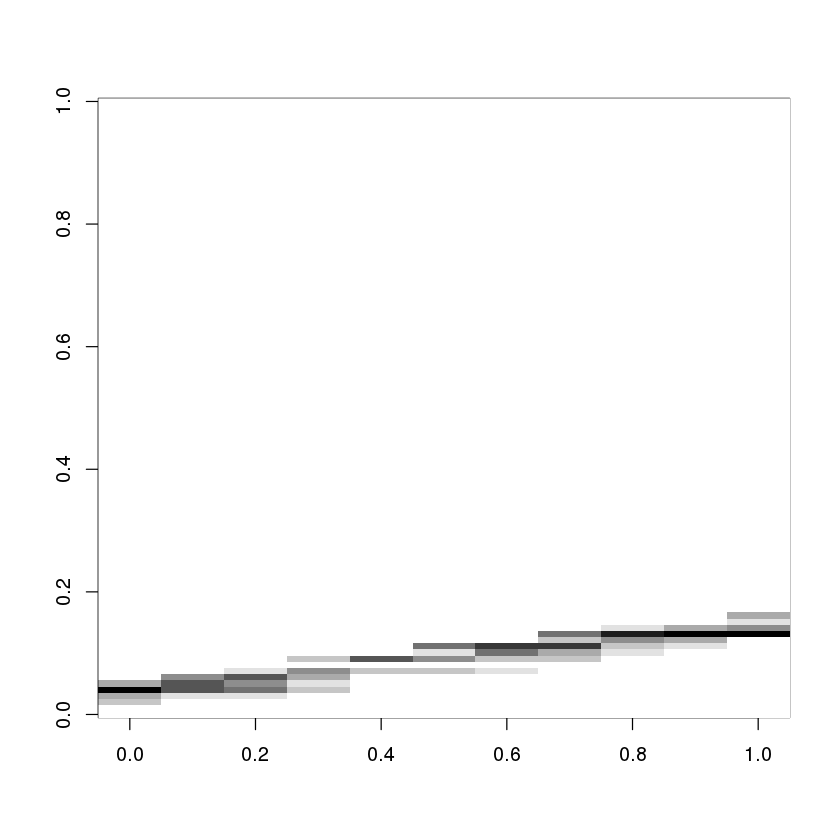

In [39]:
image(t(beta_hat), col=colfunc(10))

## coupled solution

### pick a coefficient to couple betas across time points

In [8]:
eta <- 0.0

In [9]:
X_star <- list()
for (t in time_points) {
    X_star[[t]] <- rbind(X[[t]], sqrt(N*eta)*diag(P))
}

### fit the first time point and use that to initiate the couplings

In [33]:
beta_hat_coupled <- matrix(nrow = P, ncol = length(time_points))
y_star <- list()
for (t in time_points) {
    if (t==1) {
        y_star[[t]] <- c(y[[t]], rep(0,P))
    } else {
        y_star[[t]] <- c(y[[t]], sqrt(N*eta)*beta_hat_coupled[,t-1])
    }
    fit.t <- glmnet(X_star[[t]], y_star[[t]], alpha=alpha_reasonable_value, lambda=1.0*lambda_reasonable_value,
                    intercept=FALSE, standardize=FALSE)
    beta_hat_coupled[,t] <- as.vector(fit.t$beta)
}

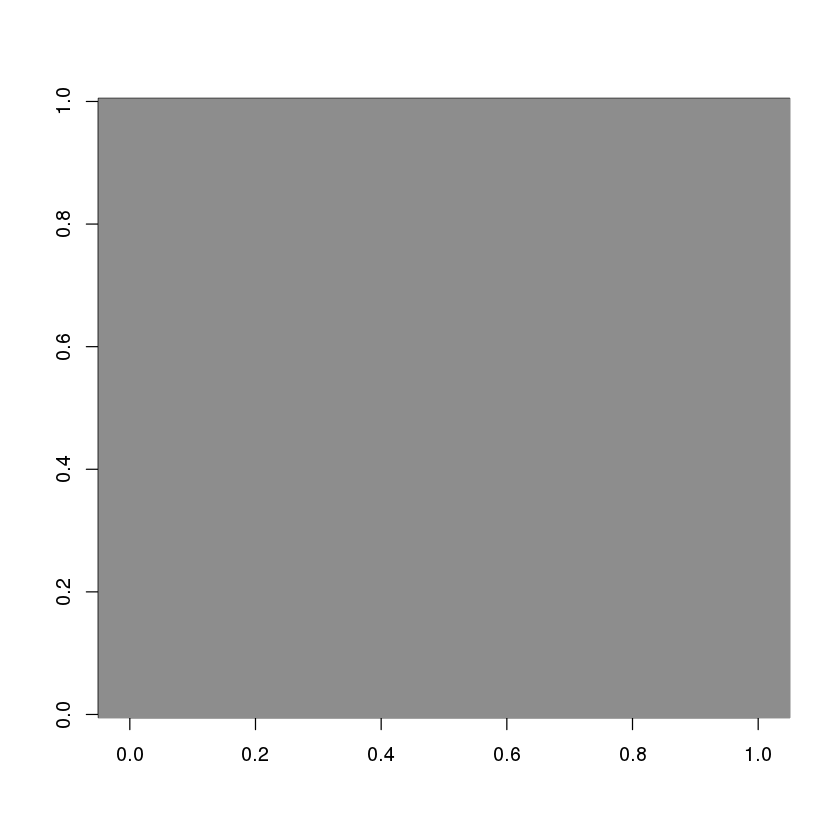

In [40]:
image(t(beta_hat_coupled), col=colfunc(10))

In [35]:
mean(beta_hat == beta_hat_coupled)

[1] 0.9481818

In [36]:
mean(beta_hat[beta_hat>0] == beta_hat_coupled[beta_hat>0])

[1] 0

In [37]:
mean(beta_hat[beta_hat_coupled>0] == beta_hat_coupled[beta_hat_coupled>0])

[1] NaN

## couple forwards and backwards, iterate until all betas converge